## **Colon Disease Classification Using EfficientNetB0**

In this notebook, we implement a deep learning model to classify colon diseases using the WCE Curated Colon Disease Dataset. The diseases included in the dataset are normal, ulcerative colitis, polyps, and esophagitis. The notebook covers the following steps:

1. **Importing Libraries**: We import necessary libraries for data manipulation, image processing, visualization, and deep learning.
2. **Data Loading and Preprocessing**: We load and preprocess the images from the dataset, including resizing images to 224x224 pixels and encoding the labels.
3. **Data Augmentation**: We apply data augmentation techniques to the training data to improve the model's generalization.
4. **Model Building**: We construct the EfficientNetB0 model, leveraging transfer learning by using pre-trained weights from ImageNet, and add custom classification layers.
5. **Model Compilation and Training**: We compile the model with the Adam optimizer and categorical cross-entropy loss function, and train it using the augmented training data.
6. **Model Evaluation**: We evaluate the model on the test set to assess its performance.
7. **Visualization**: We plot the training and validation accuracy and loss to visualize the model's learning process and identify any potential overfitting or underfitting.

The goal is to develop a robust model capable of accurately classifying different colon diseases, which can assist in early diagnosis and treatment planning.

In this cell, we import several essential libraries for data manipulation, visualization, preprocessing, and building the deep learning model.

- `os` and `cv2`: For handling file paths and image processing.
- `numpy` and `pandas`: For numerical computations and data handling.
- `matplotlib.pyplot` and `seaborn`: For creating plots and visualizations.
- `sklearn.preprocessing`: For label encoding and one-hot encoding.
- `sklearn.compose` and `sklearn.utils`: For data transformation and shuffling.
- `sklearn.model_selection`: For splitting the dataset into training and testing sets.
- `tensorflow.keras` and its submodules: For building, training, and visualizing the EfficientNetB0 deep learning model.
- `tqdm` and `tqdm.keras`: For progress bars during data loading and model training.


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
from tqdm.keras import TqdmCallback

This cell mounts Google Drive to the Colab environment, enabling access to files stored on the drive. This is necessary if the dataset and other resources are stored on Google Drive. The `drive.mount('/content/drive')` command prompts the user to authenticate and grant access.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here, we define the path to the dataset stored in Google Drive. This path will be used later to load the images and labels. Update the `dataset_path` variable to the correct location of your dataset.


In [4]:
# Path to the dataset
dataset_path = '/content/drive/MyDrive/dataset/'

We set a constant `IMG_SIZE` to 224, which defines the size to which all input images will be resized. EfficientNetB0 expects input images of size 224x224 pixels.


In [5]:
# Set Image Size for input Layer
IMG_SIZE = 224

This function, `load_data`, takes a directory name as input and loads images and their corresponding labels from that directory.

- `directory = os.path.join(dataset_path, directory)`: Combines the base dataset path with the subdirectory name.
- `images` and `labels`: Lists to store loaded images and their labels.
- `tqdm`: Provides a progress bar for the image loading process.
- `cv2.imread(image_path)`: Reads the image from the given path.
- `cv2.resize(image, (IMG_SIZE, IMG_SIZE))`: Resizes the image to 224x224 pixels.

The function returns numpy arrays of images and labels, ready for further processing.


In [6]:
# function to load images and labels from dataset
def load_data(directory):
  directory = os.path.join(dataset_path, directory)
  images = []
  labels = []
  for label in tqdm(os.listdir(directory), desc=f"Loading {os.path.basename(directory)}"):
    class_path = os.path.join(directory, label)
    for image_name in os.listdir(class_path):
      image_path = os.path.join(class_path, image_name)
      image = cv2.imread(image_path)
      image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
      images.append(image)
      labels.append(label)
  return np.array(images), np.array(labels)

We call the `load_data` function for each disease category (normal, ulcerative_colitis, polyps, esophagitis). This step loads all images and their corresponding labels from the dataset directories. 

The categories are based on the dataset structure:
- Normal
- Ulcerative Colitis
- Polyps
- Esophagitis

Each call to `load_data` will populate the `images` and `labels` arrays with data from the respective directories.


In [7]:
# Load training, validation, and test data
train_images, train_labels = load_data('train')
val_images, val_labels = load_data('val')
test_images, test_labels = load_data('test')

Loading test: 100%|██████████| 4/4 [00:46<00:00, 11.53s/it]


In [8]:
# normalize images
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

We use `LabelEncoder` from sklearn to convert the categorical labels (text) into numerical labels.

- `LabelEncoder.fit_transform(labels)`: Fits the label encoder to the labels and transforms them into a numeric form.
- `OneHotEncoder`: Converts the numerical labels into a one-hot encoded format, which is suitable for classification tasks.

One-hot encoding is necessary because the model's output layer will use a softmax activation function, which outputs a probability distribution across multiple classes.


In [9]:
# encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

In [10]:
# one hot encode labels
onehot_encoder = OneHotEncoder(sparse=False)
train_labels = onehot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels = onehot_encoder.transform(val_labels.reshape(-1, 1))
test_labels = onehot_encoder.transform(test_labels.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The Classes are based on the dataset structure:
- Normal
- Ulcerative Colitis
- Polyps
- Esophagitis

In [11]:
 # Adjusted for 4 classes: normal, ulcerative colitis, polyps, esophagitis
NUM_CLASSES = 4

We build the EfficientNetB0 model using `tensorflow.keras.applications.EfficientNetB0`.

- `include_top=False`: Excludes the top layer, as we will add our own classification layers.
- `weights='imagenet'`: Loads pre-trained weights from ImageNet, which helps in transfer learning.
- `input_shape=(IMG_SIZE, IMG_SIZE, 3)`: Defines the input shape for the model.

Transfer learning leverages pre-trained models, which can significantly speed up the training process and improve performance, especially when working with limited data.


We add custom classification layers to the EfficientNetB0 base model.

- `GlobalAveragePooling2D()`: Reduces each feature map to a single value, making the data suitable for the dense layer.
- `Dropout(0.5)`: Adds dropout regularization to reduce overfitting.
- `Dense(4, activation='softmax')`: Adds the output layer with 4 neurons (one for each class) and softmax activation.

Softmax activation is used in the output layer for multi-class classification, as it converts the output to a probability distribution.


We compile the model using the `Adam` optimizer and `categorical_crossentropy` loss function.

- `optimizer='adam'`: Uses the Adam optimizer, which is well-suited for a variety of deep learning tasks.
- `loss='categorical_crossentropy'`: Appropriate for multi-class classification problems.
- `metrics=['accuracy']`: Tracks accuracy during training and evaluation.

Compiling the model specifies the optimizer, loss function, and metrics to be used for training.


In [12]:
# function to build model
def build_model(num_classes):
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')

  # freeze all layers except the last 20
  model.trainable = True
  for layer in model.layers[:-20]:
      layer.trainable = False

  # rebuild top layer
  x = layers.GlobalAveragePooling2D(name='avg_pool')(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.5
  x = layers.Dropout(top_dropout_rate, name='top_dropout')(x)
  outputs = layers.Dense(num_classes, activation='softmax', name='pred')(x)

  # compile model
  model = tf.keras.Model(inputs, outputs, name='EfficientNet')
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [13]:
# build the model
model = build_model(num_classes=NUM_CLASSES)

16705208/16705208 [==============================] - 2s 0us/step


We use `ImageDataGenerator` from `tensorflow.keras.preprocessing.image` to augment the training data. Data augmentation helps improve the model's generalization by applying random transformations to the input images.

- `rotation_range=30`: Randomly rotates images up to 30 degrees.
- `width_shift_range=0.2` and `height_shift_range=0.2`: Randomly shifts images horizontally and vertically by up to 20%.
- `zoom_range=0.2`: Randomly zooms in on images by up to 20%.
- `horizontal_flip=True`: Randomly flips images horizontally.

These transformations create variations of the input images, which help the model learn more robust features.


In [14]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# fit the generator on your training data
datagen.fit(train_images)

We train the model using the `fit` method.

- `train_generator`: Provides augmented training data.
- `validation_data=(X_test, y_test)`: Uses the testing set for validation.
- `epochs=25`: Trains the model for 25 epochs.
- `callbacks=[TqdmCallback()]`: Adds a progress bar to the training process.

Training involves iteratively updating the model weights to minimize the loss function. Validation data helps monitor the model's performance on unseen data.


In [15]:
# train the model
epochs = 40
history = model.fit(
                 datagen.flow(train_images, train_labels, batch_size=32), \
                 validation_data=(val_images, val_labels), \
                 epochs=epochs, verbose=2, \
                 callbacks=[TqdmCallback(verbose=1)] )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/40
101/101 - 69s - loss: 2.0603 - accuracy: 0.2601 - val_loss: 1.4187 - val_accuracy: 0.2488 - 69s/epoch - 683ms/step
Epoch 2/40
101/101 - 49s - loss: 1.9397 - accuracy: 0.2808 - val_loss: 1.4249 - val_accuracy: 0.2488 - 49s/epoch - 483ms/step
Epoch 3/40
101/101 - 47s - loss: 1.9480 - accuracy: 0.2564 - val_loss: 1.4179 - val_accuracy: 0.3378 - 47s/epoch - 461ms/step
Epoch 4/40
101/101 - 49s - loss: 1.9486 - accuracy: 0.2723 - val_loss: 1.3752 - val_accuracy: 0.2488 - 49s/epoch - 481ms/step
Epoch 5/40
101/101 - 48s - loss: 1.8358 - accuracy: 0.2870 - val_loss: 1.3981 - val_accuracy: 0.2488 - 48s/epoch - 480ms/step
Epoch 6/40
101/101 - 47s - loss: 1.8074 - accuracy: 0.2883 - val_loss: 1.4124 - val_accuracy: 0.2488 - 47s/epoch - 461ms/step
Epoch 7/40
101/101 - 47s - loss: 1.8013 - accuracy: 0.3007 - val_loss: 1.5524 - val_accuracy: 0.2488 - 47s/epoch - 466ms/step
Epoch 8/40
101/101 - 47s - loss: 1.7814 - accuracy: 0.2973 - val_loss: 1.4526 - val_accuracy: 0.2488 - 47s/epoch - 467

In [16]:
additional_epochs = 40
hist_additional = model.fit(
                 datagen.flow(train_images, train_labels, batch_size=32), \
                 validation_data=(val_images, val_labels), \
                 epochs=epochs, verbose=2, \
                 callbacks=[TqdmCallback(verbose=1)] )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/40
101/101 - 60s - loss: 1.1557 - accuracy: 0.4685 - val_loss: 1.3253 - val_accuracy: 0.4174 - 60s/epoch - 592ms/step
Epoch 2/40
101/101 - 48s - loss: 1.1374 - accuracy: 0.4856 - val_loss: 1.5983 - val_accuracy: 0.3980 - 48s/epoch - 472ms/step
Epoch 3/40
101/101 - 48s - loss: 1.1119 - accuracy: 0.4903 - val_loss: 2.3236 - val_accuracy: 0.3159 - 48s/epoch - 475ms/step
Epoch 4/40
101/101 - 65s - loss: 1.1149 - accuracy: 0.4841 - val_loss: 1.3502 - val_accuracy: 0.3761 - 65s/epoch - 642ms/step
Epoch 5/40
101/101 - 53s - loss: 1.1372 - accuracy: 0.4806 - val_loss: 1.7268 - val_accuracy: 0.4348 - 53s/epoch - 527ms/step
Epoch 6/40
101/101 - 54s - loss: 1.1390 - accuracy: 0.4875 - val_loss: 4.4191 - val_accuracy: 0.2537 - 54s/epoch - 531ms/step
Epoch 7/40
101/101 - 47s - loss: 1.0997 - accuracy: 0.5006 - val_loss: 4.7485 - val_accuracy: 0.2537 - 47s/epoch - 462ms/step
Epoch 8/40
101/101 - 45s - loss: 1.0822 - accuracy: 0.5212 - val_loss: 1.1533 - val_accuracy: 0.5418 - 45s/epoch - 449

In [17]:
# model summary
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][

In [18]:
# Save the trained model
model_save_path = '/content/drive/My Drive/efficientnetb0_colon_disease_model.h5'
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
plot_model(model, show_shapes=True, \
           to_file='/content/drive/My Drive/model-architecture.png')

In [8]:
import re

# function to get training metrics values
def extract_metrics(log_text):
    loss_pattern = re.compile(r' loss: (\d+\.\d+)')
    accuracy_pattern = re.compile(r' accuracy: (\d+\.\d+)')
    val_loss_pattern = re.compile(r'val_loss: (\d+\.\d+)')
    val_accuracy_pattern = re.compile(r'val_accuracy: (\d+\.\d+)')
    
    loss_values = []
    accuracy_values = []
    val_loss_values = []
    val_accuracy_values = []
    
    loss_matches = loss_pattern.findall(log_text)
    accuracy_matches = accuracy_pattern.findall(log_text)
    val_loss_matches = val_loss_pattern.findall(log_text)
    val_accuracy_matches = val_accuracy_pattern.findall(log_text)
    
    loss_values = [float(val) for val in loss_matches]
    accuracy_values = [float(val) for val in accuracy_matches]
    val_loss_values = [float(val) for val in val_loss_matches]
    val_accuracy_values = [float(val) for val in val_accuracy_matches]
    
    return {
        'loss': loss_values,
        'accuracy': accuracy_values,
        'val_loss': val_loss_values,
        'val_accuracy': val_accuracy_values
    }

txt_file = 'training_hist.txt'
log_text = ''
with open(txt_file, 'r') as f:
    log_text = f.read()

# plot training history
history = extract_metrics(log_text)

We plot the training and validation accuracy and loss over epochs to visualize the model's performance.

- `plt.plot`: Plots the accuracy and loss curves.
- `history.history['accuracy']` and `history.history['val_accuracy']`: Training and validation accuracy.
- `history.history['loss']` and `history.history['val_loss']`: Training and validation loss.

Visualizing training history helps identify potential overfitting or underfitting issues.


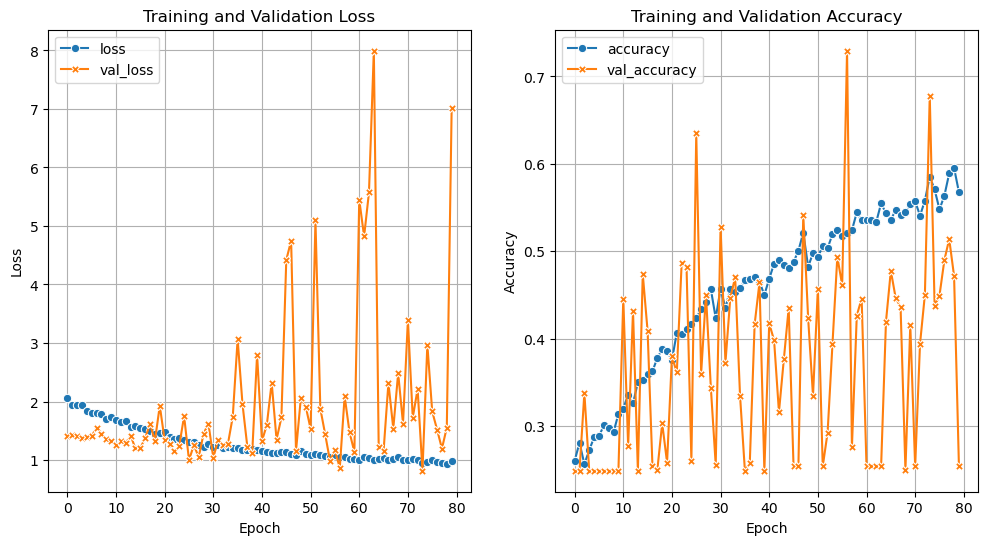

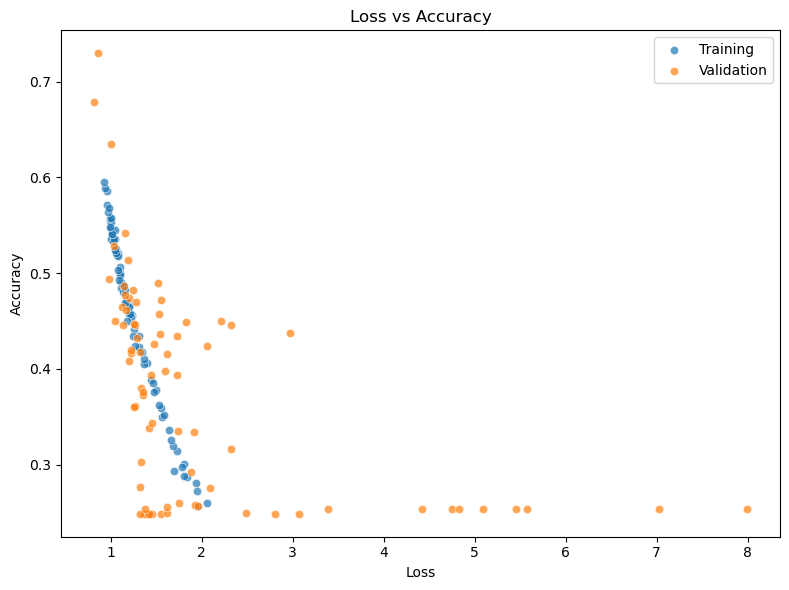

In [15]:
df = pd.DataFrame(history)

plt.figure(figsize=(12, 6))

# plot training and validation loss
plt.subplot(1, 2, 1)
sns.lineplot(data=df[['loss', 'val_loss']], markers=True, dashes=False)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# plot training and validation accuracy
plt.subplot(1, 2, 2)
sns.lineplot(data=df[['accuracy', 'val_accuracy']], markers=True, dashes=False)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# scatter plot for loss vs accuracy
plt.figure(figsize=(8, 6))
sns.scatterplot(x='loss', y='accuracy', data=df, label='Training', alpha=0.7)
sns.scatterplot(x='val_loss', y='val_accuracy', data=df, label='Validation', alpha=0.7)
plt.title('Loss vs Accuracy')
plt.xlabel('Loss')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [24]:
# evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_accuracy}")

25/25 - 2s - loss: 7.0660 - accuracy: 0.2500 - 2s/epoch - 64ms/step
Test accuracy: 0.25


1/1 [==============================] - 4s 4s/step


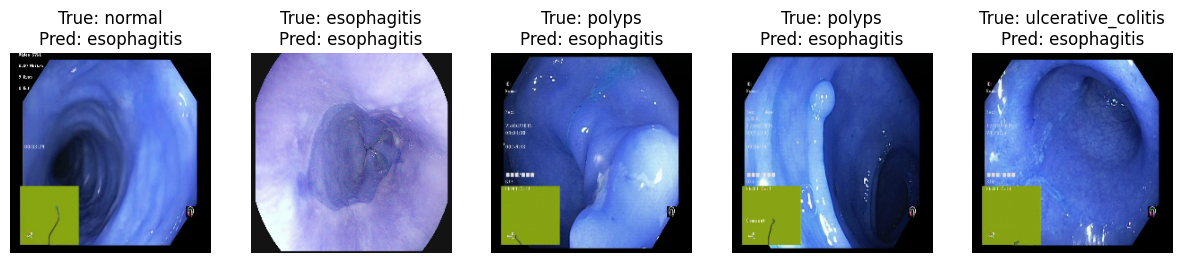

In [25]:
# function to show images and predicted labels
def plot_demo_examples(model, images, labels, num_examples=5):

    indices = np.random.choice(len(images), num_examples, replace=False)
    selected_images = images[indices]
    selected_labels = labels[indices]

    predictions = model.predict(selected_images)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 10))
    for i, index in enumerate(indices):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(selected_images[i])
        true_label = label_encoder.inverse_transform([np.argmax(selected_labels[i])])[0]
        pred_label = label_encoder.inverse_transform([predicted_labels[i]])[0]
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.show()

# plotting examples for demo
plot_demo_examples(model, test_images, test_labels, num_examples=5)